In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier


In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

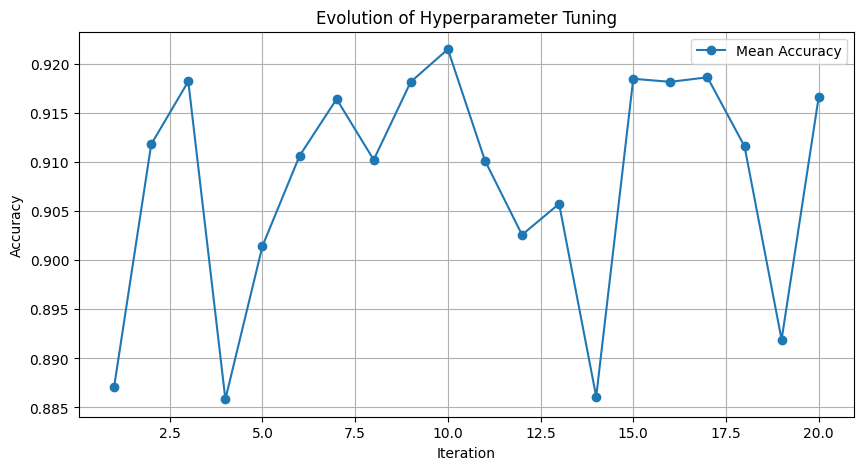

---------------------------------------------


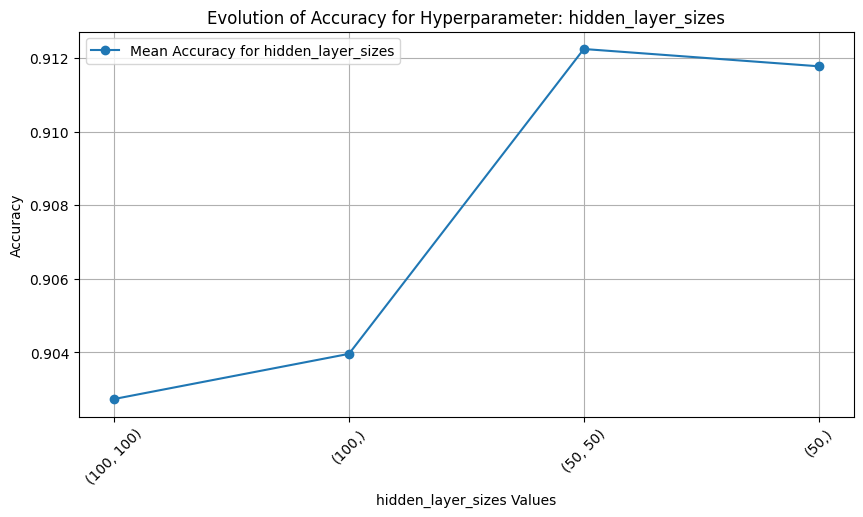

---------------------------------------------


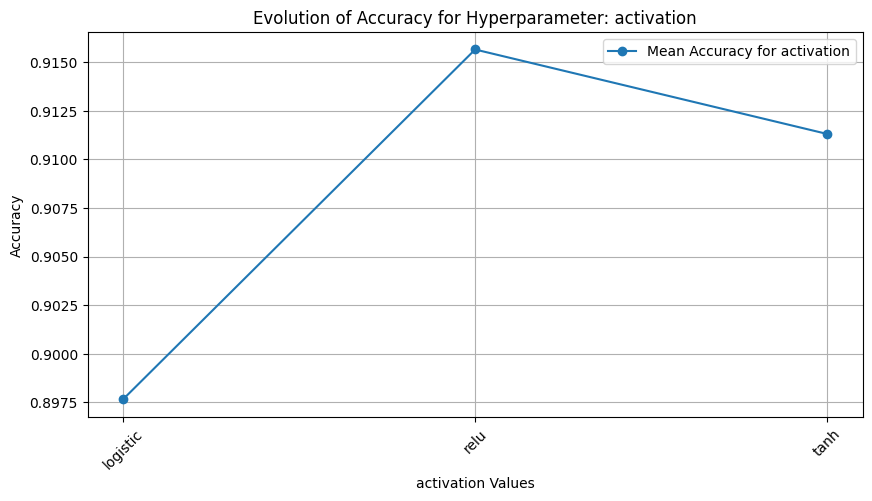

---------------------------------------------


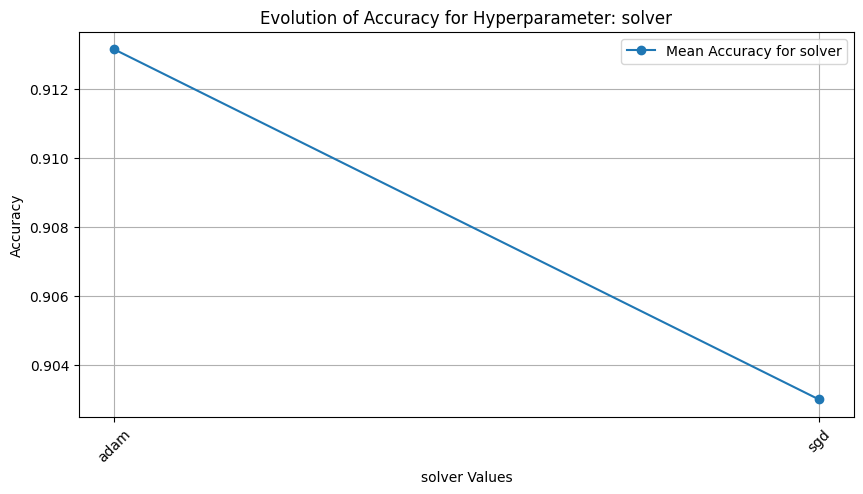

---------------------------------------------


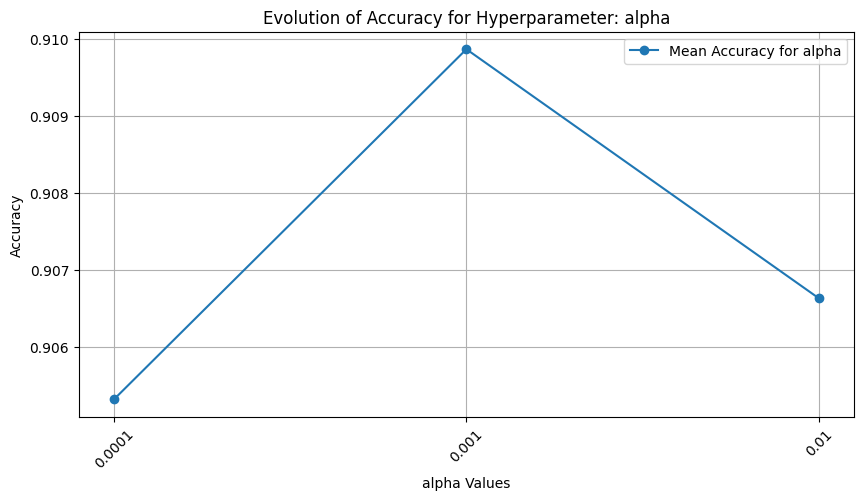

---------------------------------------------


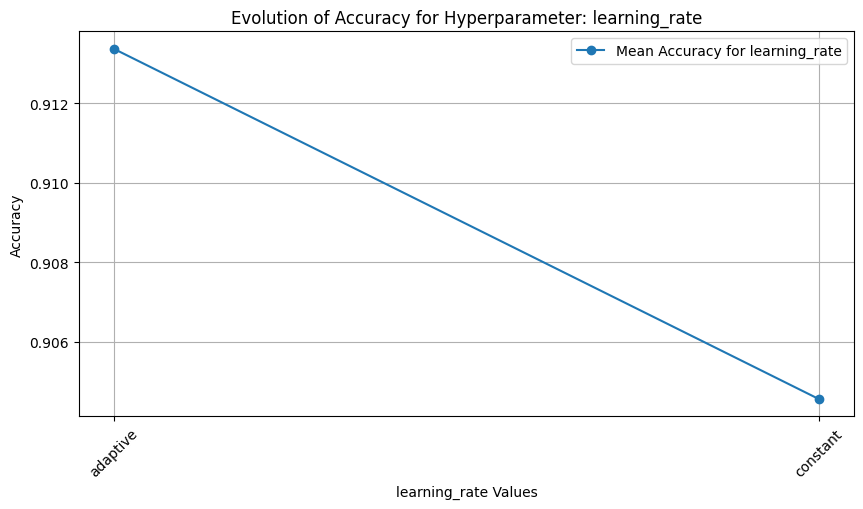

---------------------------------------------
Melhores hiperparâmetros encontrados: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50,), 'alpha': 0.001, 'activation': 'relu'}
Acurácia: 0.8944
Precisão: 0.9170
Recall: 0.9344
F1-Score: 0.9256
AUC-ROC: 0.9471


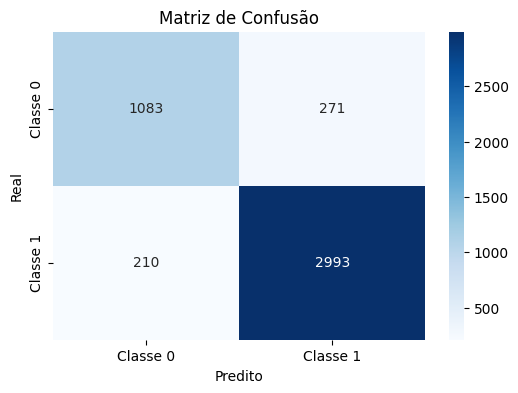


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1354
           1       0.92      0.93      0.93      3203

    accuracy                           0.89      4557
   macro avg       0.88      0.87      0.87      4557
weighted avg       0.89      0.89      0.89      4557



<ipython-input-4-e6db6e50bc76>:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette='viridis')


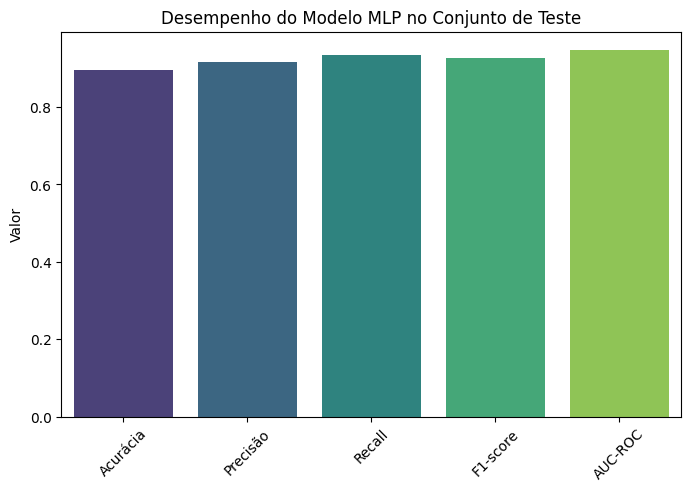

F1-score no Treino: 0.9353
F1-score no Teste: 0.9256
O modelo apresenta um equilíbrio entre treino e teste.


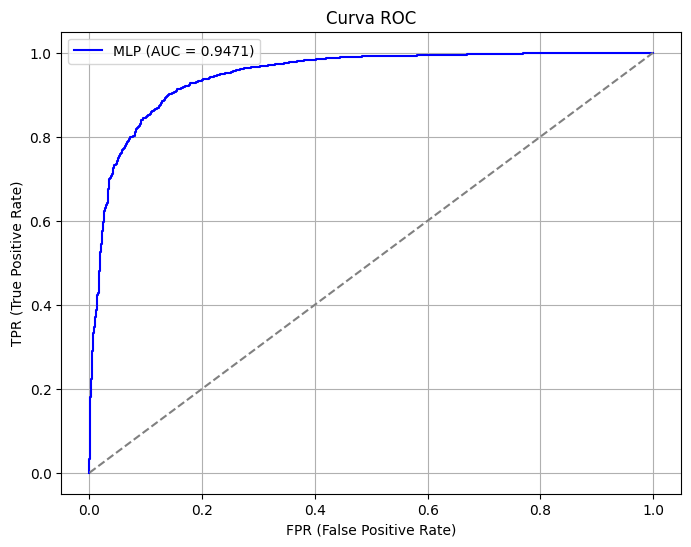

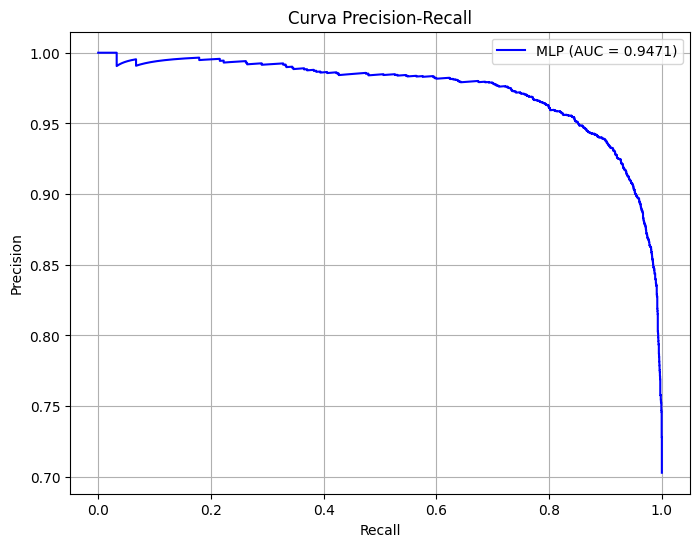

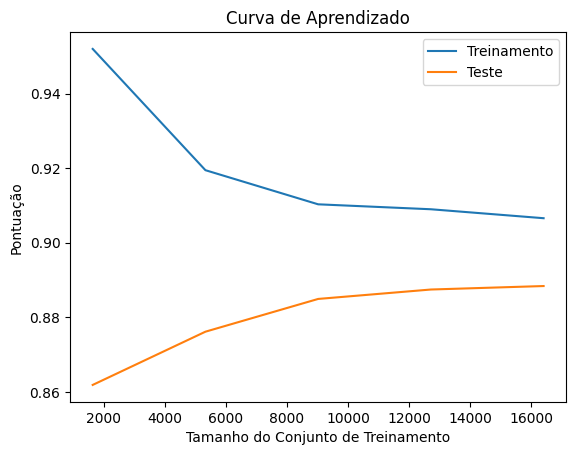


Conclusões:
O modelo MLP foi avaliado usando diversas métricas. O melhor desempenho foi atingido com os seguintes hiperparâmetros:
{'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50,), 'alpha': 0.001, 'activation': 'relu'}
Os resultados sugerem que o modelo é capaz de generalizar bem, sem sinais evidentes de overfitting ou underfitting.


In [ ]:
# 1️⃣ Separar features (X) e rótulos (y)
X_train = train_df.drop(columns=["binaryClass"])
y_train = train_df["binaryClass"]

X_test = test_df.drop(columns=["binaryClass"])
y_test = test_df["binaryClass"]

# 2️⃣ Converter classes de string para números (caso necessário)
if y_train.dtype == 'O':  # Verifica se os rótulos são texto (strings)
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)  # Transforma os rótulos do conjunto de teste também

# 3️⃣ Escalonamento dos Dados
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4️⃣ Definir o espaço de busca para os hiperparâmetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# 5️⃣ Criar o modelo MLP
mlp_model = MLPClassifier(max_iter=1000, random_state=42)

# 6️⃣ Configurar validação cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 7️⃣ Otimizar hiperparâmetros usando RandomizedSearchCV
random_search = RandomizedSearchCV(mlp_model, param_grid, n_iter=20, cv=cv, scoring='f1', n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Salvar resultados
results = pd.DataFrame(random_search.cv_results_)
results[['mean_test_score', 'std_test_score', 'params']].to_csv("hyperparameter_tuning_results.csv", index=False)

# Plotar evolução dos resultados
def plot_search_results(results):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 21), results['mean_test_score'], marker='o', linestyle='-', label='Mean Accuracy')
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Evolution of Hyperparameter Tuning")
    plt.legend()
    plt.grid()
    plt.show()
    print('---------------------------------------------')

plot_search_results(results)

def plot_hyperparameter_evolution(results, param_name):
    # Filtrar as colunas relevantes para o hiperparâmetro
    param_values = [str(param) for param in results['param_' + param_name]]
    mean_scores = results['mean_test_score']
    std_scores = results['std_test_score']

    # Criar um DataFrame com as informações
    df = pd.DataFrame({
        'param_value': param_values,
        'mean_score': mean_scores,
        'std_score': std_scores
    })

    # Agrupar por valor do hiperparâmetro e calcular a média da acurácia
    df_grouped = df.groupby('param_value').agg({'mean_score': 'mean', 'std_score': 'mean'}).reset_index()

    # Plotar a evolução da média da acurácia
    plt.figure(figsize=(10, 5))
    plt.plot(df_grouped['param_value'], df_grouped['mean_score'], marker='o', linestyle='-', label=f'Mean Accuracy for {param_name}')
    plt.xlabel(f"{param_name} Values")
    plt.ylabel("Accuracy")
    plt.title(f"Evolution of Accuracy for Hyperparameter: {param_name}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()
    print('---------------------------------------------')

for param_name in param_grid.keys():
    plot_hyperparameter_evolution(results, param_name)

# 8️⃣ Melhor modelo encontrado
best_mlp = random_search.best_estimator_
print(f"Melhores hiperparâmetros encontrados: {random_search.best_params_}")

# 9️⃣ Reajustar o modelo final com os melhores parâmetros
best_mlp.fit(X_train_scaled, y_train)

# 🔟 Avaliação no conjunto de teste
y_pred = best_mlp.predict(X_test_scaled)
y_prob = best_mlp.predict_proba(X_test_scaled)[:, 1]  # Probabilidade para a classe positiva

# Cálculo das métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

# Exibir os resultados
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# 🔥 Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# 📊 Visualizar Matriz de Confusão
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# 1. Comparação de Desempenho
metrics = [accuracy, precision, recall, f1, auc_roc]
labels = ["Acurácia", "Precisão", "Recall", "F1-score", "AUC-ROC"]
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=metrics, palette='viridis')
plt.title("Desempenho do Modelo MLP no Conjunto de Teste")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()

# 2. Overfitting vs. Underfitting
train_pred = best_mlp.predict(X_train_scaled)
train_f1 = f1_score(y_train, train_pred)
print(f"F1-score no Treino: {train_f1:.4f}")
print(f"F1-score no Teste: {f1:.4f}")

if train_f1 - f1 > 0.1:
    print("O modelo pode estar sofrendo de overfitting.")
elif f1 - train_f1 > 0.1:
    print("O modelo pode estar sofrendo de underfitting.")
else:
    print("O modelo apresenta um equilíbrio entre treino e teste.")

# 3. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {auc_roc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("Curva ROC")
plt.legend()
plt.grid()
plt.show()

# 4. Curva Precision-Recall
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'MLP (AUC = {auc_roc:.4f})', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid()
plt.show()

# 5. Curva de Aprendizado
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(best_mlp, X_train_scaled, y_train, cv=cv, n_jobs=-1)
plt.plot(train_sizes, train_scores.mean(axis=1), label="Treinamento")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Teste")
plt.xlabel("Tamanho do Conjunto de Treinamento")
plt.ylabel("Pontuação")
plt.legend()
plt.title("Curva de Aprendizado")
plt.show()

# 6. Conclusões
print("\nConclusões:")
print("O modelo MLP foi avaliado usando diversas métricas. O melhor desempenho foi atingido com os seguintes hiperparâmetros:")
print(random_search.best_params_)
print("Os resultados sugerem que o modelo é capaz de generalizar bem, sem sinais evidentes de overfitting ou underfitting.")